In [16]:
import time
from collections import defaultdict
import json
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
# List of all the scoring metrics (regression and classification)
# sorted(sklearn.metrics.SCORERS.keys())

In [4]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

# Look into using sklearn StratifiedGroupKFold to choose 15 RBG and 15 FBG when pulling from 'all' data
### This will level the n_samples playing field with RBG-only and FBG-only
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html

# None of the Group CV classes seem to be able to pull 15 from each group with a continuous y output 
## Solution would be to simply pull 30 random samples from all 60 in 'all' and do lots of repeats

# Don't forget to scale data for SVM

In [134]:
X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']         # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                            # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])

In [46]:
# def grid_search(X, y, model, params, cv, scoring, print_all=True, **kwargs):
#     gs = GridSearchCV(estimator=model,
#                       param_grid=params,
#                       scoring=scoring,
#                       cv=cv,
#                       n_jobs=7,
#                       error_score='raise',
#                       refit=False,
#                       **kwargs)
#     result = gs.fit(X, y)
#     if not result.multimetric_: # multimetric_ = whether multiple scores input
#         print("Best: %f using %s" % (result.best_score_, result.best_params_))
#         means = result.cv_results_['mean_test_score']
#         stds = result.cv_results_['std_test_score']
#         params = result.cv_results_['params']
#         if print_all:
#             for mean, stdev, param in zip(means, stds, params):
#                 print("%f (%f) with: %r" % (mean, stdev, param))
#     l = []
#     for mean, param in zip(means, params):
#         d = {'mean': mean, **param}
#         l.append(d)
#     return pd.DataFrame(l)

In [52]:
# gs = GridSearchCV(
#     SVR(),
#     param_grid={'kernel': ['rbf', 'linear']}, 
#     scoring=['r2', 'neg_mean_squared_error'],
# #     scoring=['r2'],
#     cv=RepeatedKFold(n_splits=10, n_repeats=5),
#     n_jobs=7,
#     error_score='raise',
#     refit=False,
# )
# result = gs.fit(X_all, y_ogtt)
# pd.DataFrame(result.cv_results_).filter(regex='split.*r2')

In [170]:
for train, test in RepeatedKFold(n_splits=11, n_repeats=1, random_state=1).split(X_all.loc[rbg_cols]):
    print(train, test)

[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 18 19 20 22 23 24 25 26
 27 28 29] [10 17 21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 21 22 23 24 25 26
 27 28 29] [14 19 20]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 27 28 29] [ 3 24 26]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26
 27 28 29] [ 4 22 23]
[ 0  1  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26
 27 28 29] [ 2  6 25]
[ 0  1  2  3  4  5  6  8  9 10 11 12 14 15 16 17 19 20 21 22 23 24 25 26
 27 28 29] [ 7 13 18]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 28 29] [ 1 16 27]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28] [ 0 15 29]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 29] [ 9 28]
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29] [ 8 12]
[ 0  1  2  3  4  6  7  8  9 10 12 13 14 15 16 17 1

In [171]:
def custom_random_fasted_split10(n_repeats=5, random_state=1):
    """
    Only works for n_splits=10 on 30 total samples
    
    Because we are comparing only-random vs. only-fasted vs. all data, 
    only-random and only-fasted are at a disadvantage because they have 30 samples, 
    and 'all' has 60 samples, thus 'all' gets more training data.
    To compensate, at each split, pull random sample of 15 RBG and 15 FBG, 
    and get a list of (train, test) labels similar to the sklearn splitters.
    
    return list of (train_list, test_list) indexes
    """
    random.seed(random_state)
    
    n_splits = 10
    
    sample_indices = pd.Series(range(len(X_all)), index=X_all.index)
    custom_cv = []  # custom_cv splitter must return a list of (train, test) tuples
    for _ in range(n_repeats):
        samples = sample_indices.loc[random.sample(rbg_cols.to_list(), 15)].to_list() + \
                  sample_indices.loc[random.sample(fbg_cols.to_list(), 15)].to_list()
        for j in range(n_splits):
            start = 3 * j  # start and end are very brittle because of the 3 * j. Therefore only use n_splits=10
            end = 3 * j + 3
            test = samples[start:end]
            train = list(set(samples).difference(test))
            custom_cv.append((train, test))
    return custom_cv

In [179]:
def data_subset_hyperparam_search(
    model, param_grid, X_all,  # 'y' parameter not needed because it appears in y_list
    columns_list, column_names, y_list, y_names, 
    n_splits=10, n_repeats=5, results=defaultdict(dict)):
    """
    Performs grid search across data subsets (RBG vs. FBG vs. All),
    and y predictions (OGTT, Insulin, Weight, BG, etc.)
    
    Returns dataframe labeled with hyperparam grid search and prediction results 
    """
    for column_name in column_names:
        if column_name not in ['RBG', 'FBG', 'all']:
            raise ValueError('Bad column names')
    
    for columns, column_name in zip(columns_list, column_names):
        for y, y_name in zip(y_list, y_names):
            if column_name == 'all':
                cv = custom_random_fasted_split10(n_repeats=n_repeats, random_state=1)
            elif column_name == 'RBG' or column_name == 'FBG':
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
            else:
                raise ValueError('column_name is not "all" or "RBG" or "FBG"')
            print(column_name, y_name)
            results[column_name][y_name] = \
                GridSearchCV(model, 
                             param_grid,
                             scoring='neg_mean_absolute_percentage_error',
                             n_jobs=-2,  # -2 uses all but 1 core
                             refit=False,
                             cv=cv,
                             verbose=2,  # verbosity prints to the Anaconda Command prompt, so intercept it? 
                            ).fit(X_all.loc[columns], y.loc[columns]).cv_results_
    
    results = dict(results)
    dfs = []
    for columns in column_names:
        for y_name in y_names:
            df = pd.DataFrame(results[columns][y_name])
            df['data_subset'] = columns
            df['y_type'] = y_name
            dfs.append(df)
    return pd.concat(dfs).reset_index(drop=True)

In [182]:
test = data_subset_hyperparam_search(
    model=SVR(), 
    param_grid={'kernel': ['linear', 'rbf', 'poly']}, 
    X_all=X_all,  
    columns_list=[rbg_cols, fbg_cols, data_cols], 
    column_names=['RBG', 'FBG', 'all'], 
    y_list=[y_ogtt, y_weight], 
    y_names=['ogtt', 'weight'],
)

RBG ogtt
Fitting 50 folds for each of 3 candidates, totalling 150 fits
RBG weight
Fitting 50 folds for each of 3 candidates, totalling 150 fits
FBG ogtt
Fitting 50 folds for each of 3 candidates, totalling 150 fits
FBG weight
Fitting 50 folds for each of 3 candidates, totalling 150 fits
all ogtt
Fitting 50 folds for each of 3 candidates, totalling 150 fits
all weight
Fitting 50 folds for each of 3 candidates, totalling 150 fits


In [184]:
test

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score,data_subset,y_type
0,0.029439,0.003294,0.027179,0.003514,linear,{'kernel': 'linear'},-0.043876,-0.076931,-0.168424,-0.122737,...,-0.111463,-0.062412,-0.121891,-0.157180,-0.082717,-0.127792,0.058247,1,RBG,ogtt
1,0.028299,0.003414,0.027159,0.003640,rbf,{'kernel': 'rbf'},-0.180996,-0.130602,-0.040698,-0.147092,...,-0.134995,-0.147030,-0.104430,-0.463363,-0.529198,-0.310162,0.164070,3,RBG,ogtt
2,0.029379,0.003757,0.027879,0.004008,poly,{'kernel': 'poly'},-0.181201,-0.130641,-0.040643,-0.146981,...,-0.134847,-0.147286,-0.104163,-0.464176,-0.527543,-0.310103,0.164066,2,RBG,ogtt
3,0.029439,0.004243,0.028279,0.005196,linear,{'kernel': 'linear'},-0.014288,-0.060435,-0.039915,-0.024108,...,-0.039114,-0.012730,-0.044775,-0.040981,-0.025496,-0.033133,0.012735,1,RBG,weight
4,0.027259,0.002270,0.026399,0.002441,rbf,{'kernel': 'rbf'},-0.016718,-0.080927,-0.014647,-0.016893,...,-0.050724,-0.043841,-0.066435,-0.059213,-0.069067,-0.060202,0.026598,3,RBG,weight
5,0.028060,0.002949,0.026899,0.003401,poly,{'kernel': 'poly'},-0.017137,-0.081918,-0.013185,-0.012428,...,-0.052311,-0.047947,-0.063306,-0.063215,-0.057126,-0.058870,0.027896,2,RBG,weight
6,0.028799,0.003376,0.027959,0.003950,linear,{'kernel': 'linear'},-0.246071,-0.228210,-0.444716,-0.086552,...,-0.310227,-0.172022,-0.092023,-0.271352,-0.054758,-0.163131,0.098003,1,FBG,ogtt
7,0.029379,0.002629,0.028719,0.003000,rbf,{'kernel': 'rbf'},-0.340739,-0.600676,-0.773773,-0.164115,...,-0.521565,-0.297608,-0.176963,-0.358219,-0.222467,-0.310297,0.185459,2,FBG,ogtt
8,0.029760,0.002902,0.027019,0.003421,poly,{'kernel': 'poly'},-0.341045,-0.600609,-0.774163,-0.163870,...,-0.521530,-0.297544,-0.177081,-0.358135,-0.222345,-0.310352,0.185539,3,FBG,ogtt
9,0.028339,0.003327,0.027340,0.003277,linear,{'kernel': 'linear'},-0.055443,-0.088985,-0.070852,-0.041532,...,-0.085005,-0.053921,-0.035133,-0.037253,-0.022462,-0.044092,0.023343,1,FBG,weight


In [137]:
model = SVR()
# C and gamma search space from https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
C = np.logspace(-5, 15, num=11, base=2.0)
gamma = np.logspace(-15, 5, num=11, base=2.0)
param_grid = [
    {'kernel': ['linear'], 'C': C},
    {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': gamma, 'C': C}]
results = defaultdict(dict)
n_splits = 10
n_repeats = 5
for i, (cols, col_name) in enumerate(zip([data_cols, rbg_cols, fbg_cols, ], ['all', 'RBG', 'FBG'])):
    for y, y_name in zip([y_ogtt, y_weight], ['ogtt', 'weight']):
        if col_name == 'all':
            cv = custom_random_fasted_split(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
        else:
            cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
        print(col_name, y_name)
        results[col_name][y_name] = \
            GridSearchCV(model, 
                         param_grid,
                         scoring='neg_mean_absolute_percentage_error',
                         n_jobs=-2,  # uses all but 1 core
                         refit=False,
                         cv=cv,
                         verbose=2,  # verbosity prints to the Anaconda Command prompt, so intercept it? 
                        ).fit(X_all.loc[cols], y.loc[cols]).cv_results_

all ogtt
Fitting 50 folds for each of 374 candidates, totalling 18700 fits
all weight
Fitting 50 folds for each of 374 candidates, totalling 18700 fits
RBG ogtt
Fitting 50 folds for each of 374 candidates, totalling 18700 fits
RBG weight
Fitting 50 folds for each of 374 candidates, totalling 18700 fits
FBG ogtt
Fitting 50 folds for each of 374 candidates, totalling 18700 fits
FBG weight
Fitting 50 folds for each of 374 candidates, totalling 18700 fits


In [139]:
results = dict(results)
dfs = []
for bg_type in ['RBG', 'FBG', 'all']:
    for y_name in ['ogtt', 'weight']:
        df = pd.DataFrame(results[bg_type][y_name])
        df['bg_type'] = bg_type
        df['y_type'] = y_name
        dfs.append(df)
svr = pd.concat(dfs)
# svr.to_csv(r'..\models\params\SVR_params.csv')

param_C         0.03125      0.12500      0.50000      2.00000      \
bg_type y_type                                                       
FBG     ogtt      -0.280255    -0.208588    -0.164952    -0.162404   
        weight    -0.044092    -0.044092    -0.044092    -0.044092   
RBG     ogtt      -0.222649    -0.179980    -0.136457    -0.127792   
        weight    -0.033133    -0.033133    -0.033133    -0.033133   
all     ogtt      -0.266624    -0.219377    -0.164306    -0.155401   
        weight    -0.040765    -0.040765    -0.040765    -0.040765   

param_C         8.00000      32.00000     128.00000    512.00000    \
bg_type y_type                                                       
FBG     ogtt      -0.162404    -0.162404    -0.162404    -0.162404   
        weight    -0.044092    -0.044092    -0.044092    -0.044092   
RBG     ogtt      -0.127792    -0.127792    -0.127792    -0.127792   
        weight    -0.033133    -0.033133    -0.033133    -0.033133   
all     ogtt      -0.155401    -0.155401    -0.155401    -0.155401   
        weight    -0.040765    -0.040765    -0.040765    -0.040765   

param_C         2048.00000   8192.00000   32768.00000  
bg_type y_type                                         
FBG     ogtt      -0.162404    -0.162404    -0.162404  
        weight    -0.044092    -0.044092    -0.044092  
RBG     ogtt      -0.127792    -0.127792    -0.127792  
        weight    -0.033133    -0.033133    -0.033133  
all     ogtt      -0.155401    -0.155401    -0.155401  
        weight    -0.040765    -0.040765    -0.040765

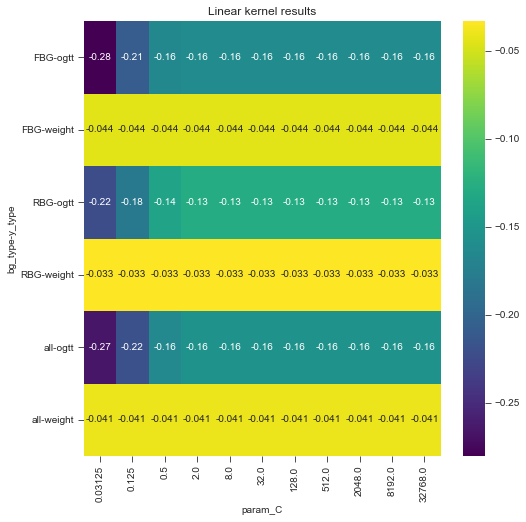

In [140]:
# for bg_type in svr.bg_type.unique():
#     for y_type in svr.y_type.unique():
# #         df = svr.loc[(svr['bg_type'] == bg_type) & (svr['y_type'] == y_type) & (svr['param_kernel'] == 'linear')]
# #         display(df)
df = svr.loc[(svr['param_kernel'] == 'linear')]
df = df.pivot(columns='param_C', index=['bg_type', 'y_type'], values='mean_test_score')
display(df)
sns.heatmap(df, cmap='viridis', annot=True)
plt.title('Linear kernel results')
plt.gcf().set_size_inches(8, 8)

In [167]:
for bg_type in ['RBG', 'FBG', 'all']:
    df = svr.loc[(svr['param_kernel'] == 'linear') & (svr['y_type'] == 'ogtt') & (svr['bg_type'] == bg_type)]
    print(f'best linear kernel C param for {bg_type}:', df.iloc[df['mean_test_score'].idxmax()]['params'])
    display(df.iloc[df['mean_test_score'].idxmax()])
#     display(df)

best linear kernel C param for RBG: {'C': 2.0, 'kernel': 'linear'}


mean_fit_time      0.022362
std_fit_time       0.001453
mean_score_time    0.020725
std_score_time     0.001371
param_C                 2.0
                     ...   
mean_test_score   -0.127792
std_test_score     0.058247
rank_test_score           2
bg_type                 RBG
y_type                 ogtt
Name: 3, Length: 63, dtype: object

best linear kernel C param for FBG: {'C': 2.0, 'kernel': 'linear'}


mean_fit_time      0.047584
std_fit_time       0.007907
mean_score_time    0.042129
std_score_time     0.005433
param_C                 2.0
                     ...   
mean_test_score   -0.162404
std_test_score     0.098189
rank_test_score           3
bg_type                 FBG
y_type                 ogtt
Name: 3, Length: 63, dtype: object

best linear kernel C param for all: {'C': 0.5, 'kernel': 'linear'}


mean_fit_time      0.049742
std_fit_time       0.004888
mean_score_time    0.043274
std_score_time     0.004579
param_C                 0.5
                     ...   
mean_test_score   -0.124092
std_test_score     0.048108
rank_test_score           3
bg_type                 all
y_type                 ogtt
Name: 2, Length: 63, dtype: object

# predict OGTT with linear kernel:
1. RBG C = 2 is best with avg error of 12.8%
2. FBG C=2, error = 16.2%
3. All C=0.5, error = 12.4%

RBG ogtt rbf
RBG bg rbf
FBG ogtt rbf
FBG bg rbf
all ogtt rbf
all bg rbf


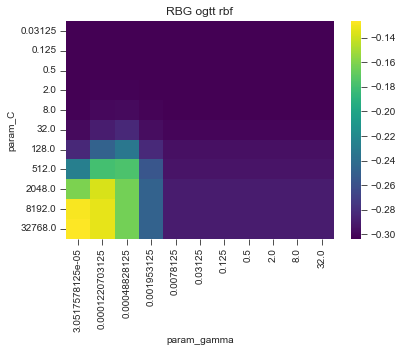

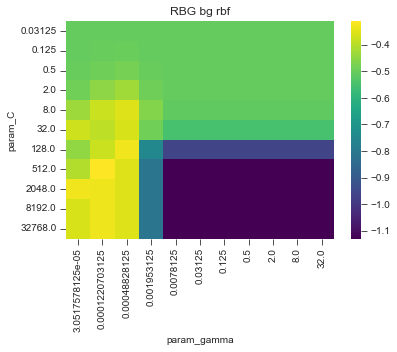

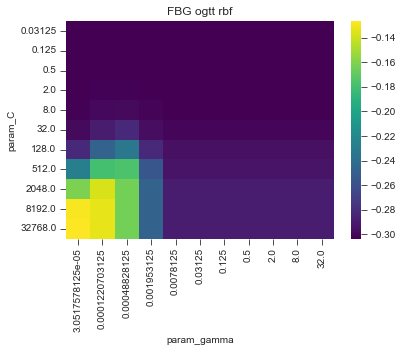

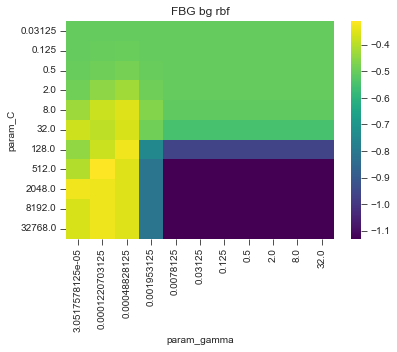

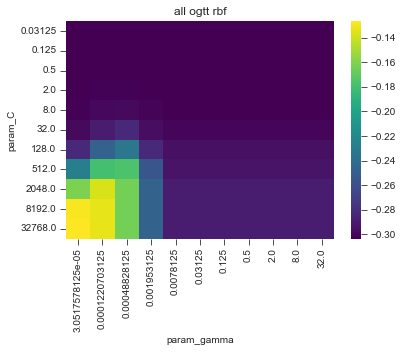

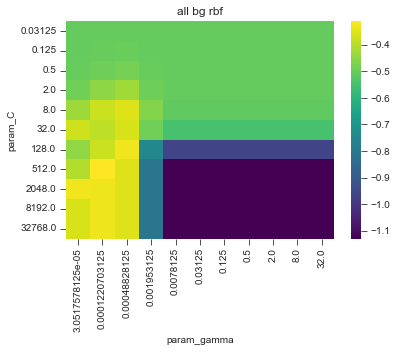

In [117]:
for bg_type in svr.bg_type.unique():
    for y_type in svr.y_type.unique():
        for kernel in [
#             'poly', 
            'rbf', 
#             'sigmoid'
        ]:
            print(bg_type, y_type, kernel)
            df = svr.loc[(svr['bg_type'] == bg_type) & (svr['y_type'] == y_type) & (svr['param_kernel'] == kernel)]
            df = df.pivot(index='param_C', columns='param_gamma', values='mean_test_score')
#             display(df)
            plt.figure()
            
            sns.heatmap(df, cmap='viridis')
            plt.title(str(bg_type) + ' ' + str(y_type) + ' ' + str(kernel))
        
#         svr.loc[(svr['bg_type'] == 'RBG') & (svr['y_type'] == 'ogtt')]

In [135]:
np.logspace(10, 25, num=16, base=2.0).astype('int')

array([    1024,     2048,     4096,     8192,    16384,    32768,
          65536,   131072,   262144,   524288,  1048576,  2097152,
        4194304,  8388608, 16777216, 33554432])

In [136]:
model = SVR()
# C and gamma search space from https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
C = np.logspace(10, 30, num=21, base=2.0)  # 32768 to 33554432
gamma = np.logspace(-30, -10, num=21, base=2.0)
param_grid = {'kernel': ['rbf'], 'gamma': gamma, 'C': C}
results2 = defaultdict(dict)
for i, (cols, col_name) in enumerate(zip([rbg_cols, fbg_cols, data_cols], ['RBG', 'FBG', 'all'])):
    for y, y_name in zip([y_ogtt, y_bg], ['ogtt', 'bg']):
        print(col_name, y_name)
        results2[col_name][y_name] = \
            GridSearchCV(model, 
                         param_grid,
                         scoring='neg_mean_absolute_percentage_error',
                         n_jobs=-1,
                         refit=False,
                         cv=RepeatedKFold(n_splits=10, n_repeats=5, random_state=1),
                         verbose=2,).fit(X_all.loc[cols], y.loc[cols]).cv_results_

RBG ogtt
Fitting 50 folds for each of 441 candidates, totalling 22050 fits
RBG bg
Fitting 50 folds for each of 441 candidates, totalling 22050 fits
FBG ogtt
Fitting 50 folds for each of 441 candidates, totalling 22050 fits
FBG bg
Fitting 50 folds for each of 441 candidates, totalling 22050 fits
all ogtt
Fitting 50 folds for each of 441 candidates, totalling 22050 fits
all bg
Fitting 50 folds for each of 441 candidates, totalling 22050 fits


In [168]:
results2 = dict(results2)
dfs = []
for bg_type in ['RBG', 'FBG', 'all']:
    for y_name in ['ogtt', 'bg']:
        df = pd.DataFrame(results2[bg_type][y_name])
        df['bg_type'] = bg_type
        df['y_type'] = y_name
        dfs.append(df)
svr2 = pd.concat(dfs)

RBG ogtt rbf
RBG bg rbf
FBG ogtt rbf
FBG bg rbf
all ogtt rbf
all bg rbf


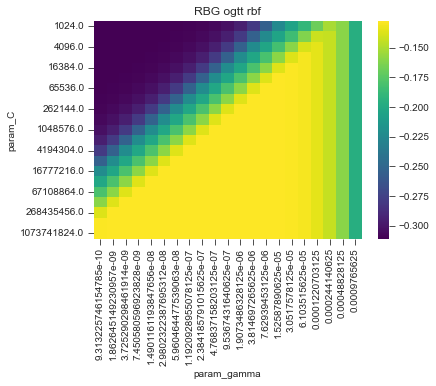

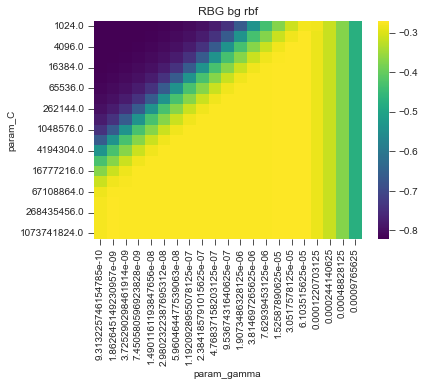

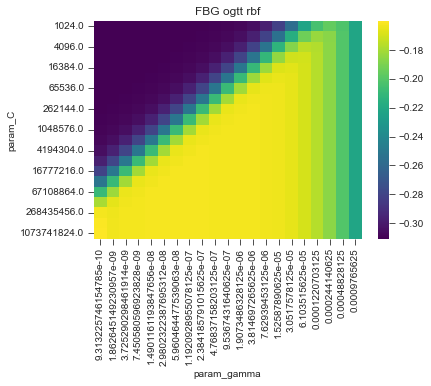

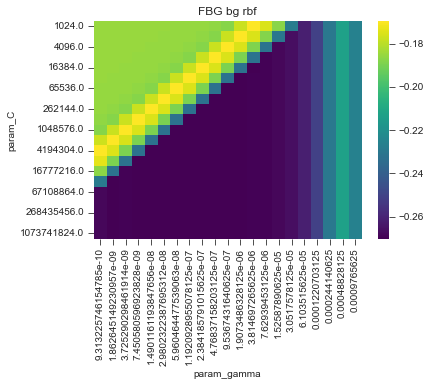

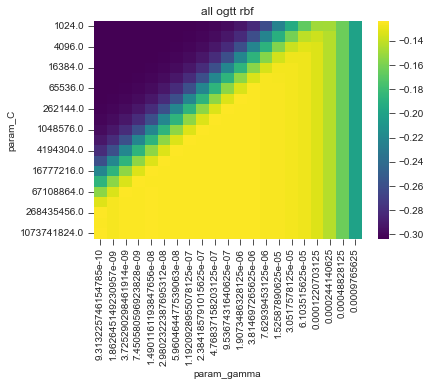

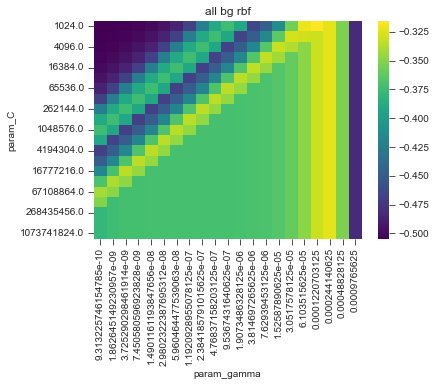

In [169]:
for bg_type in svr2.bg_type.unique():
    for y_type in svr2.y_type.unique():
        for kernel in [
#             'poly', 
            'rbf', 
#             'sigmoid'
        ]:
            print(bg_type, y_type, kernel)
            df = svr2.loc[(svr2['bg_type'] == bg_type) & \
                          (svr2['y_type'] == y_type) & \
                          (svr2['param_kernel'] == kernel)]
            df = df.pivot(index='param_C', columns='param_gamma', values='mean_test_score')
#             display(df)
            plt.figure()
            
            sns.heatmap(df, cmap='viridis')
            plt.title(str(bg_type) + ' ' + str(y_type) + ' ' + str(kernel))
        
#         svr.loc[(svr['bg_type'] == 'RBG') & (svr['y_type'] == 'ogtt')]

# Conclusions

1. First round of hyperparameter search in the log2 logspace suggests that RBF kernel can be further optimized with more extreme values
2. This was tested and showed that RBF is only slightly worse than linear
    1. This is not worth the loss of interpretability arising from RBF kernel

## Feature importance with SVM Regression

In [ ]:
RepeatedStratifiedKFold

In [177]:
coef_results = {'RBG': 0, 'FBG': 0, 'all': 0}

for cols, bg_type in zip([rbg_cols, fbg_cols, data_cols], ['RBG', 'FBG', 'all']):
    X = X_all.loc[cols]
    y = y_ogtt.loc[cols]
    n_repeats=100
    for train, test in RepeatedKFold(n_splits=10, 
                                     n_repeats=n_repeats, 
                                     random_state=1,).split(X, y):
        model = SVR(C=2.0, kernel='linear').fit(X.iloc[train], y.iloc[train])
        coef_results[bg_type] += model.coef_

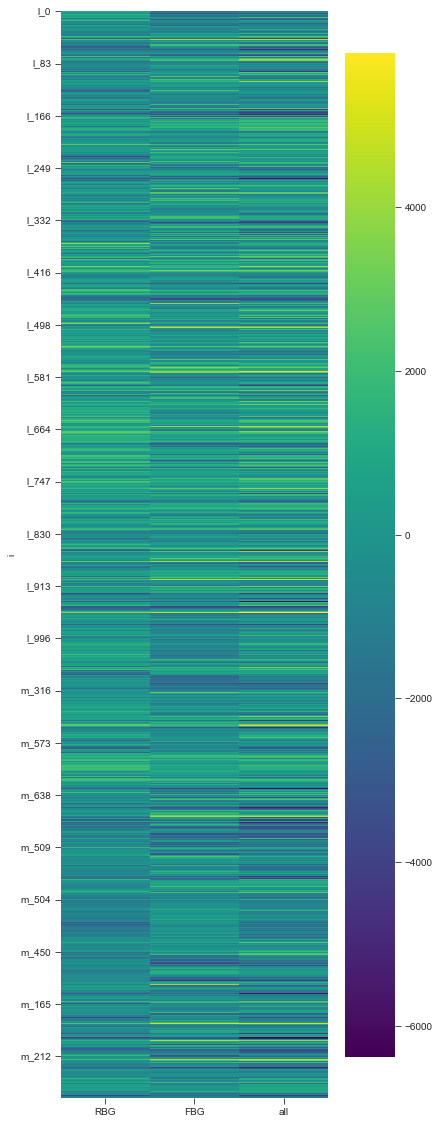

In [207]:
coefs = pd.DataFrame([coef_results['RBG'][0], coef_results['FBG'][0], coef_results['all'][0]],
             columns=data.index, index=['RBG', 'FBG', 'all']).T
sns.heatmap(coefs, cmap='viridis', )
plt.gcf().set_size_inches((6, 20))

# coefs.to_csv(r'..\models\feat_importances\SVR.csv')

In [57]:
pd.DataFrame(results['RBG']['ogtt'].to_dict())

,mean,C,kernel,gamma
0,-0.223181,0.031250,linear,NaN
1,-0.175429,0.145816,linear,NaN
2,-0.129474,0.680395,linear,NaN
3,-0.127254,3.174802,linear,NaN
4,-0.127254,14.813995,linear,NaN
...,...,...,...,...
305,-0.297740,32768.000000,rbf,6.857952
306,-92.466012,32768.000000,sigmoid,6.857952
307,-0.181698,32768.000000,poly,32.000000
308,-0.297740,32768.000000,rbf,32.000000


In [53]:
for d in ['bg', 'ogtt']:
    for bg in ['RBG', 'FBG', 'all']:
        print(bg, d)
        df = results[bg][d]
#         display(df.groupby('kernel').mean())
#         display(df)
        display(df.loc[df['kernel'] == 'rbf'])
#         display(df.loc[df['kernel'] == 'rbf'].groupby('gamma').mean())

RBG bg


,mean,C,kernel,gamma
11,-0.817365,0.03125,rbf,0.000031
14,-0.817135,0.03125,rbf,0.000142
17,-0.817073,0.03125,rbf,0.000664
20,-0.817440,0.03125,rbf,0.003100
23,-0.817466,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.783280,32768.00000,rbf,0.067504
299,-0.783280,32768.00000,rbf,0.314980
302,-0.783280,32768.00000,rbf,1.469734
305,-0.783280,32768.00000,rbf,6.857952


FBG bg


,mean,C,kernel,gamma
11,-0.185258,0.03125,rbf,0.000031
14,-0.185254,0.03125,rbf,0.000142
17,-0.185237,0.03125,rbf,0.000664
20,-0.185256,0.03125,rbf,0.003100
23,-0.185256,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.275935,32768.00000,rbf,0.067504
299,-0.275935,32768.00000,rbf,0.314980
302,-0.275935,32768.00000,rbf,1.469734
305,-0.275935,32768.00000,rbf,6.857952


all bg


,mean,C,kernel,gamma
11,-0.503658,0.03125,rbf,0.000031
14,-0.502919,0.03125,rbf,0.000142
17,-0.502678,0.03125,rbf,0.000664
20,-0.503907,0.03125,rbf,0.003100
23,-0.503947,0.03125,rbf,0.014467
...,...,...,...,...
296,-1.130529,32768.00000,rbf,0.067504
299,-1.130529,32768.00000,rbf,0.314980
302,-1.130529,32768.00000,rbf,1.469734
305,-1.130529,32768.00000,rbf,6.857952


RBG ogtt


,mean,C,kernel,gamma
11,-0.311063,0.03125,rbf,0.000031
14,-0.311048,0.03125,rbf,0.000142
17,-0.311045,0.03125,rbf,0.000664
20,-0.311065,0.03125,rbf,0.003100
23,-0.311066,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.297740,32768.00000,rbf,0.067504
299,-0.297740,32768.00000,rbf,0.314980
302,-0.297740,32768.00000,rbf,1.469734
305,-0.297740,32768.00000,rbf,6.857952


FBG ogtt


,mean,C,kernel,gamma
11,-0.311540,0.03125,rbf,0.000031
14,-0.311537,0.03125,rbf,0.000142
17,-0.311532,0.03125,rbf,0.000664
20,-0.311536,0.03125,rbf,0.003100
23,-0.311537,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.297247,32768.00000,rbf,0.067504
299,-0.297247,32768.00000,rbf,0.314980
302,-0.297247,32768.00000,rbf,1.469734
305,-0.297247,32768.00000,rbf,6.857952


all ogtt


,mean,C,kernel,gamma
11,-0.303286,0.03125,rbf,0.000031
14,-0.303276,0.03125,rbf,0.000142
17,-0.303274,0.03125,rbf,0.000664
20,-0.303287,0.03125,rbf,0.003100
23,-0.303288,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.288315,32768.00000,rbf,0.067504
299,-0.288315,32768.00000,rbf,0.314980
302,-0.288315,32768.00000,rbf,1.469734
305,-0.288315,32768.00000,rbf,6.857952


In [58]:
with open(r'..\models\hyperparameters.json', 'r') as infile:
    hp = json.load(infile)

In [59]:
hp

{'reg': {'RBG': {'ogtt': {}, 'bg': {}},
  'FBG': {'ogtt': {}, 'bg': {}},
  'all': {'ogtt': {}, 'bg': {}}}}

,-15,-13,-11,-9,-7,-5,-3,-1,1,3
C,,,,,,,,,,
0.031250,-0.303286,-0.303276,-0.303274,-0.303287,-0.303288,-0.303288,-0.303288,-0.303288,-0.303288,-0.303288
0.145816,-0.303269,-0.303222,-0.303211,-0.303274,-0.303278,-0.303278,-0.303278,-0.303278,-0.303278,-0.303278
0.680395,-0.303189,-0.302968,-0.302913,-0.303211,-0.303234,-0.303234,-0.303234,-0.303234,-0.303234,-0.303234
3.174802,-0.302818,-0.301775,-0.301521,-0.302919,-0.303024,-0.303024,-0.303024,-0.303024,-0.303024,-0.303024
14.813995,-0.301066,-0.296186,-0.295019,-0.301556,-0.302049,-0.302049,-0.302049,-0.302049,-0.302049,-0.302049
69.123823,-0.292884,-0.269596,-0.265997,-0.295616,-0.297637,-0.297637,-0.297637,-0.297637,-0.297637,-0.297637
322.539789,-0.255450,-0.196595,-0.203078,-0.283596,-0.291277,-0.291277,-0.291277,-0.291277,-0.291277,-0.291277
1505.008120,-0.174409,-0.140374,-0.178122,-0.275552,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315
7022.542708,-0.127795,-0.134100,-0.178122,-0.275552,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315


<AxesSubplot:ylabel='C'>

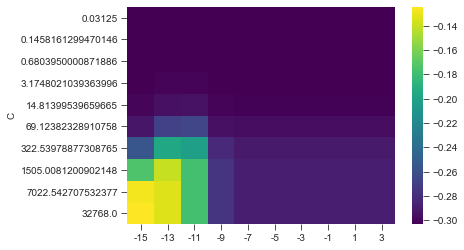

In [68]:
pivot = df.loc[df['kernel'] == 'rbf', ['mean', 'C', 'gamma']].pivot('C', 'gamma')
pivot.columns = np.arange(-15, 5, 2)
display(pivot)

sns.heatmap(pivot, cmap='viridis')

<AxesSubplot:ylabel='C'>

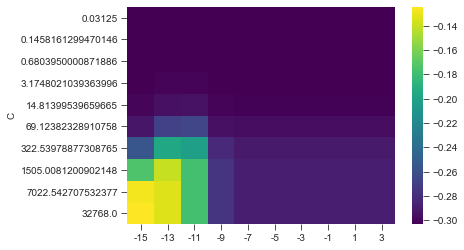

In [46]:
results['RBG']['bg'].groupby('kernel').mean()  # kernel C  bg  ogtt  RBG  FBG  all

,mean,C
kernel,,
linear,-0.296067,0.747273
poly,-0.288324,0.747273
rbf,-0.810622,0.747273


In [14]:
model = SVR()
param_grid = {'kernel': ['rbf', 'linear'],
              'C': [0.1, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.96, 0.98, 1.0]}
gs = GridSearchCV(
    model, 
    param_grid, 
    cv=10,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=7,
    )
gs_result_all_ogtt = gs.fit(X_all, y_ogtt)

# summarize results
print("Best: %f using %s" % (gs_result_all_ogtt.best_score_, gs_result_all_ogtt.best_params_))
means = gs_result_all_ogtt.cv_results_['mean_test_score']
stds = gs_result_all_ogtt.cv_results_['std_test_score']
params = gs_result_all_ogtt.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.118269 using {'C': 0.9, 'kernel': 'linear'}
-0.307511 (0.077348) with: {'C': 0.1, 'kernel': 'rbf'}
-0.180080 (0.052390) with: {'C': 0.1, 'kernel': 'linear'}
-0.307386 (0.077298) with: {'C': 0.4, 'kernel': 'rbf'}
-0.131720 (0.039868) with: {'C': 0.4, 'kernel': 'linear'}
-0.307303 (0.077265) with: {'C': 0.6, 'kernel': 'rbf'}
-0.122239 (0.044749) with: {'C': 0.6, 'kernel': 'linear'}
-0.307261 (0.077249) with: {'C': 0.7, 'kernel': 'rbf'}
-0.120474 (0.046193) with: {'C': 0.7, 'kernel': 'linear'}
-0.307218 (0.077233) with: {'C': 0.8, 'kernel': 'rbf'}
-0.118752 (0.046856) with: {'C': 0.8, 'kernel': 'linear'}
-0.307197 (0.077225) with: {'C': 0.85, 'kernel': 'rbf'}
-0.118371 (0.047042) with: {'C': 0.85, 'kernel': 'linear'}
-0.307175 (0.077217) with: {'C': 0.9, 'kernel': 'rbf'}
-0.118269 (0.047122) with: {'C': 0.9, 'kernel': 'linear'}
-0.307162 (0.077213) with: {'C': 0.93, 'kernel': 'rbf'}
-0.118276 (0.047168) with: {'C': 0.93, 'kernel': 'linear'}
-0.307149 (0.077208) with: {'C': 0.96, 

In [11]:
gs_result_all_ogtt

GridSearchCV(cv=10, estimator=SVR(), n_jobs=7,
             param_grid={'C': [0.1, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.96,
                               0.98, 1.0],
                         'kernel': ['rbf', 'linear']})